In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
import yfinance as yf
from itertools import combinations
import seaborn as sns
from datetime import datetime, date, timedelta
import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor
# Initialize global variables
ip = '3.109.28.121'
conn = psycopg2.connect(
    dbname='qdb',
    user='admin',
    host=ip,
    port='8812',
    password='quest'
)
cursor = conn.cursor(cursor_factory=RealDictCursor)
# Function to fetch all unique symbols
def getAllUniqueSymbols():
    global conn, cursor
    query = "SELECT DISTINCT Symbol FROM NSE_STOCKS;"
    try:
        cursor.execute(query)
    except Exception as e:
        print(f"Error fetching symbols: {e}")
        conn.close()
        conn = psycopg2.connect(
            dbname='qdb',
            user='admin',
            host=ip,
            port='8812',
            password='quest'
        )
        cursor = conn.cursor(cursor_factory=RealDictCursor)
        cursor.execute(query)
    symbols = [row['Symbol'] for row in cursor.fetchall()]
    return symbols
# Function to fetch backtest data
def getBackTestDataStock(symbol, startDate, endDate, timeframe):
    global conn, cursor  # Referencing global connection and cursor
    # Format dates
    if isinstance(startDate, date):
        startDate = startDate.strftime('%Y-%m-%d')
    if isinstance(endDate, date):
        endDate = endDate.strftime('%Y-%m-%d')
    endDate = datetime.strptime(endDate, '%Y-%m-%d') + timedelta(days=1)
    endDate = endDate.strftime('%Y-%m-%d')
    # SQL Query with dynamic timeframe
    query_ = f"""
        WITH meta_query AS (
            SELECT *
            FROM NSE_STOCKS
            WHERE Symbol = 'NSE:{symbol}' AND Datetime >= '{startDate}' AND Datetime < '{endDate}'
        )
        SELECT
            min(datetime) AS datetime,
            first(open) AS Open,
            max(high) AS High,
            min(low) AS Low,
            last(close) AS Close,
            sum(volume) AS Volume
        FROM meta_query
        SAMPLE BY {timeframe};
    """
    try:
        cursor.execute(query_)
    except Exception as e:
        print(f"Error executing query: {e}")
        try:
            cursor.close()
            cursor = conn.cursor()
        except:
            conn.close()
            conn = psycopg2.connect(
                dbname='qdb',
                user='admin',
                host=ip,
                port='8812',
                password='quest'
            )
            cursor = conn.cursor(cursor_factory=RealDictCursor)
            cursor.execute(query_)
    # Convert results to DataFrame
    df = pd.DataFrame(cursor.fetchall())
    # print(df)
    return df



class PairsTrader:
    def __init__(self, symbols, start_date, end_date, timeframe):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.timeframe = timeframe
        self.data = None

    def fetch_data(self):
        data = {}
        for symbol in self.symbols:
            stock = yf.Ticker(symbol)
            data[symbol] = stock.history(start=self.start_date, end=self.end_date)['Close']
        self.data = pd.DataFrame(data)
        self.data.dropna(inplace=True)

    # def fetch_data(self):
    #     global getBackTestDataStock  # Use the provided function
    #     data = {}
    #     for symbol in self.symbols:
    #         df = getBackTestDataStock(symbol, self.start_date, self.end_date, self.timeframe)
    #         if df is not None and not df.empty:
    #             data[symbol] = df.set_index('datetime')['Close']
    #     self.data = pd.DataFrame(data)
    #     self.data.dropna(inplace=True)



    def save_cointegrated_pairs(self, output_file="cointegrated_pairs.csv"):
        pairs_data = []
        for symbol1, symbol2 in combinations(self.symbols, 2):
            data1 = self.data[symbol1]
            data2 = self.data[symbol2]
            _, pvalue, _ = coint(data1, data2)

            if pvalue < 0.05:
                model = OLS(data1, data2)
                results = model.fit()
                beta = results.params[0]
                spread = data1 - beta * data2
                adf_result = adfuller(spread)[1]

                if adf_result < 0.05:
                    pairs_data.append({
                        "Pair": f"{symbol1}-{symbol2}",
                        "Coint P-Value": pvalue,
                        "ADF P-Value": adf_result,
                        "Beta": beta
                    })

        pairs_df = pd.DataFrame(pairs_data)
        pairs_df.to_csv(output_file, index=False)
        print(f"Cointegrated pairs saved to {output_file}")
        return pairs_df
    


class SinglePairTrader:
    def __init__(self, symbol1, symbol2, data1, data2, lots_s1, lots_s2):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.data = pd.DataFrame({symbol1: data1, symbol2: data2})
        self.lots_s1 = lots_s1
        self.lots_s2 = lots_s2
        self.beta = None
        self.spread = None
        self.rolling_mean = None
        self.rolling_std = None
        self.positions = None
        self.pnl = None
        self.total_return = None
        self.sharpe_ratio = None
        self.max_drawdown = None
        self.coint_pvalue = None
        self.adf_pvalue = None
        self.price_diff = None
        self.winrate = None

    def test_cointegration(self):
        coint_pvalue = coint(self.data[self.symbol1], self.data[self.symbol2])[1]
        self.coint_pvalue = coint_pvalue
        return coint_pvalue < 0.05

    def calculate_spread(self):
        model = OLS(self.data[self.symbol1], self.data[self.symbol2])
        results = model.fit()
        self.beta = results.params[0]
        self.spread = self.data[self.symbol1] - self.beta * self.data[self.symbol2]
        self.rolling_mean = self.spread.rolling(window=75).mean()
        self.rolling_std = self.spread.rolling(window=75).std()

    def test_spread_stationarity(self):
        adf_pvalue = adfuller(self.spread.dropna())[1]
        self.adf_pvalue = adf_pvalue
        return adf_pvalue < 0.05

    def generate_signals(self):
        signals = pd.DataFrame(index=self.data.index)
        signals['signal'] = 0
        upper_band = self.rolling_mean + 2 * self.rolling_std
        lower_band = self.rolling_mean - 2 * self.rolling_std
        signals.loc[self.spread > upper_band, 'signal'] = -1
        signals.loc[self.spread < lower_band, 'signal'] = 1
        signals.loc[(self.spread <= upper_band) & (self.spread >= lower_band), 'signal'] = 0
        return signals

    def backtest(self):
        signals = self.generate_signals()
        self.positions = signals.shift(1)
        price_diff = self.lots_s1 * self.data[self.symbol1] - self.beta * self.lots_s2 * self.data[self.symbol2]
        self.price_diff = price_diff
        self.pnl = self.positions['signal'] * price_diff.diff()
        self.pnl = self.pnl[self.pnl != 0]

    def calculate_metrics(self):
        self.total_return = self.pnl.sum()
        self.sharpe_ratio = np.sqrt(252) * self.pnl.mean() / self.pnl.std()
        self.max_drawdown = ((self.pnl.cumsum() - self.pnl.cumsum().cummax()) / self.pnl.cumsum().cummax()).min()
        self.beta = self.beta
        self.coint_pvalue = self.coint_pvalue
        self.adf_pvalue = self.adf_pvalue
        self.winrate = (self.pnl > 0).sum() / len(self.pnl)

    def plot_results(self):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 15))
        ax1.plot(self.data)
        ax1.set_title('Stock Prices')
        ax1.legend([self.symbol1, self.symbol2])
        ax2.plot(self.spread, label='Spread')
        ax2.plot(self.rolling_mean, label='Rolling Mean', color='orange')
        ax2.plot(self.rolling_mean + 2 * self.rolling_std, label='Upper Band', color='green', linestyle='--')
        ax2.plot(self.rolling_mean - 2 * self.rolling_std, label='Lower Band', color='red', linestyle='--')
        ax2.legend()
        ax2.set_title('Spread with Rolling Bands')
        ax3.plot(self.pnl.cumsum(), label='Cumulative PnL')
        ax3.set_title('Cumulative PnL')
        ax3.legend()
        ax4.plot(self.pnl, label='PnL')
        ax4.set_title('PnL')
        ax4.legend()
        ax5.plot(self.price_diff, label='Price Difference')
        ax5.set_title('Price Difference')
        ax5.legend()
        plt.tight_layout()
        plt.show()







In [24]:
# Example usage with 50 stocks from NSE index

# symbols = ['RELIANCE', 'HINDUNILVR' , 'CIPLA', 'SBILIFE', 'KOTAKBANK', 'ASIANPAINT', 'MARUTI',
#                 'HDFCBANK', 'HDFCLIFE', 'TCS', 'BAJFINANCE', 'BPCL', 'VEDL', 'SHREECEM',
#                     'ADANIPORTS', 'HCLTECH', 'GRASIM', 'INFY', 'ADANIENT', 'SBIN', 'DRREDDY', 'HINDALCO',
#                         'ADANIGREEN', 'JSWSTEEL', 'SUNPHARMA', 'BAJAJFINSV', 'EICHERMOT', 'DIVISLAB',
#                             'AXISBANK', 'ICICIBANK', 'TECHM', 'ONGC', 'TITAN', 'BHARTIARTL', 'TATASTEEL',
#                                 'TATAMOTORS', 'POWERGRID', 'M&M', 'ULTRACEMCO', 'WIPRO', 'BRITANNIA', 'NESTLEIND',
#                                     'ITC', 'LT', 'GAIL', 'HEROMOTOCO', 'IOC', 'NTPC', 'COALINDIA', 'BAJAJ-AUTO']

symbols = ['RELIANCE.NS', 'HINDUNILVR.NS' , 'CIPLA.NS', 'SBILIFE.NS', 'KOTAKBANK.NS', 'ASIANPAINT.NS', 'MARUTI.NS',
                'HDFCBANK.NS', 'HDFCLIFE.NS', 'TCS.NS', 'BAJFINANCE.NS', 'BPCL.NS', 'VEDL.NS', 'SHREECEM.NS',
                    'ADANIPORTS.NS', 'HCLTECH.NS', 'GRASIM.NS', 'INFY.NS', 'ADANIENT.NS', 'SBIN.NS', 'DRREDDY.NS', 'HINDALCO.NS',
                        'ADANIGREEN.NS', 'JSWSTEEL.NS', 'SUNPHARMA.NS', 'BAJAJFINSV.NS', 'EICHERMOT.NS', 'DIVISLAB.NS',
                            'AXISBANK.NS', 'ICICIBANK.NS', 'TECHM.NS', 'ONGC.NS', 'TITAN.NS', 'BHARTIARTL.NS', 'TATASTEEL.NS',
                                'TATAMOTORS.NS', 'POWERGRID.NS', 'M&M.NS', 'ULTRACEMCO.NS', 'WIPRO.NS', 'BRITANNIA.NS', 'NESTLEIND.NS',
                                    'ITC.NS', 'LT.NS', 'GAIL.NS', 'HEROMOTOCO.NS', 'IOC.NS', 'NTPC.NS', 'COALINDIA.NS', 'BAJAJ-AUTO.NS']
           

start_date = '2021-01-01'
end_date = '2025-01-01'
timeframe = '1d'  # Set intraday timeframe (hourly prices)
pairs_trader = PairsTrader(symbols, start_date, end_date, timeframe)
pairs_trader.fetch_data()
cointegrated_pairs = pairs_trader.save_cointegrated_pairs()
print(cointegrated_pairs)


Cointegrated pairs saved to cointegrated_pairs.csv
                           Pair  Coint P-Value  ADF P-Value       Beta
0        RELIANCE.NS-SBILIFE.NS       0.025737     0.014053   0.928876
1        CIPLA.NS-ADANIPORTS.NS       0.016057     0.011055   1.194825
2            CIPLA.NS-GRASIM.NS       0.003810     0.000228   0.599933
3              CIPLA.NS-SBIN.NS       0.037045     0.006847   1.933800
4         CIPLA.NS-EICHERMOT.NS       0.022185     0.005205   0.327517
5         CIPLA.NS-ICICIBANK.NS       0.035934     0.007337   1.249442
6          SBILIFE.NS-MARUTI.NS       0.046677     0.036831   0.136989
7    KOTAKBANK.NS-BAJFINANCE.NS       0.000372     0.014640   0.269345
8      KOTAKBANK.NS-SHREECEM.NS       0.000653     0.024111   0.071183
9    KOTAKBANK.NS-BAJAJFINSV.NS       0.000352     0.016034   1.178689
10            MARUTI.NS-SBIN.NS       0.020314     0.017457  15.916572
11        MARUTI.NS-AXISBANK.NS       0.017070     0.002530  10.121362
12           TCS.NS-HINDAL

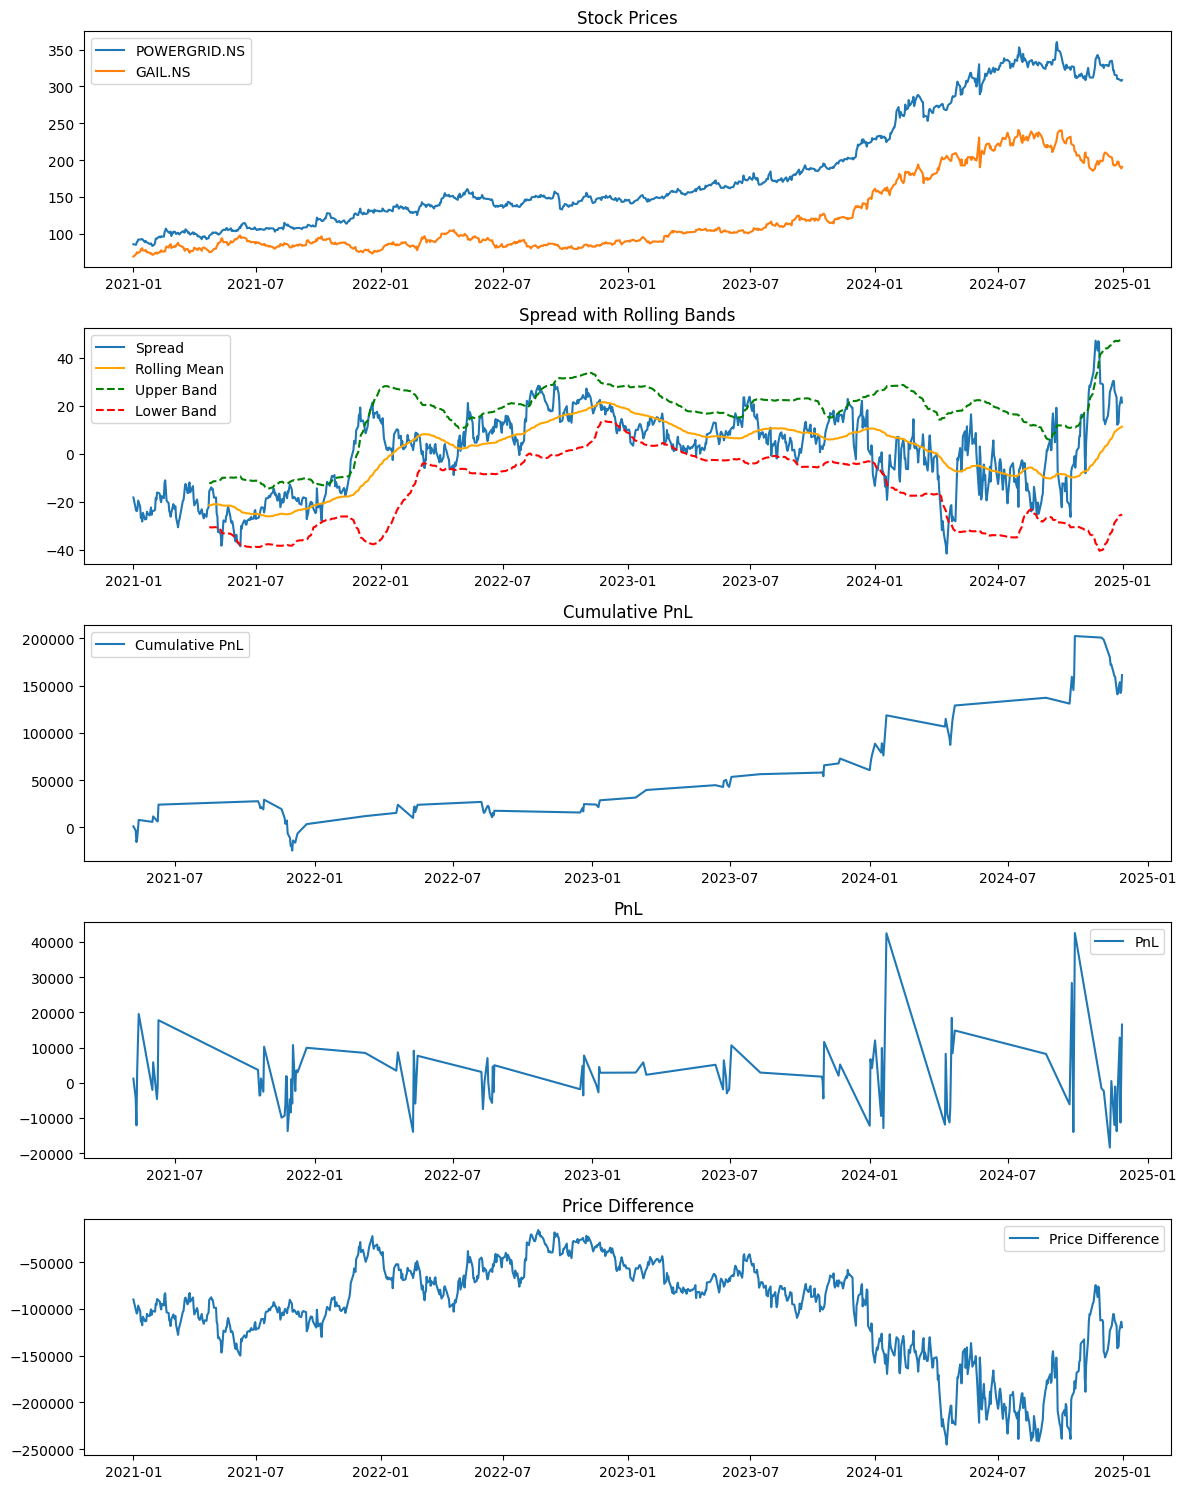

161202.9151544057
2.260996812483856
-14.510607073256324
0.5478260869565217


In [26]:
# Execute pair trader for Powergrid (1800 lot size) and GAIL (2350 lot size)
symbol1 = 'POWERGRID.NS'
symbol2 = 'GAIL.NS'
data1 = pairs_trader.data[symbol1]
data2 = pairs_trader.data[symbol2]
lots_s1 = 1800
lots_s2 = 2350
pair_trader = SinglePairTrader(symbol1, symbol2, data1, data2, lots_s1, lots_s2)
if pair_trader.test_cointegration():
    pair_trader.calculate_spread()
    if pair_trader.test_spread_stationarity():
        pair_trader.backtest()
        pair_trader.calculate_metrics()
        pair_trader.plot_results()
        print(pair_trader.total_return)
        print(pair_trader.sharpe_ratio)
        print(pair_trader.max_drawdown)
        print(pair_trader.winrate)
    else:
        print("Spread is not stationary")